In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import unittest

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [9]:
class GooglePlayAnalyzer:
    def __init__(self, path: str):
        self.path = path
        self.df = None
    
    def load_data(self) -> None:
        try:
            self.df = pd.read_csv(self.path)
            print(f"Wczytano plik. Wierszy: {self.df.shape[0]}")
        except Exception as e:
            print(f"Błąd wczytywania: {e}")

    @staticmethod
    def parse_size(size_str):
        if isinstance(size_str, str):
            if 'M' in size_str:
                return float(size_str.replace('M', '')) * 1_000_000
            elif 'k' in size_str:
                return float(size_str.replace('k', '')) * 1_000
        return np.nan

    def clean_data(self) -> None:
        if self.df is None: return
        print("Czyszczenie danych...")
        
        # 1. Usuwanie błędnych ocen
        self.df = self.df[self.df['Rating'] <= 5]
        
        # 2. Naprawa kolumny Installs
        self.df['Installs'] = self.df['Installs'].astype(str).str.replace('+', '').str.replace(',', '')
        self.df['Installs'] = pd.to_numeric(self.df['Installs'], errors='coerce')
        
        # 3. Naprawa Size i Price
        self.df['Size'] = self.df['Size'].apply(self.parse_size)
        self.df['Price'] = self.df['Price'].astype(str).str.replace('$', '')
        self.df['Price'] = pd.to_numeric(self.df['Price'], errors='coerce')

        # 4. Zamieniamy recenzje na liczby (czasem są tam śmieci, więc errors='coerce' zamieni je na NaN)
        self.df['Reviews'] = pd.to_numeric(self.df['Reviews'], errors='coerce')
        
        self.df.dropna(inplace=True)
        print("Dane wyczyszczone i gotowe.")

    def show_analysis(self):
        if self.df is None: return
        print("\nStatystyki opisowe:")
        display(self.df.describe())
        
        plt.figure(figsize=(10, 6))
        # Sprawdzamy korelację dla wszystkich liczb (w tym Reviews!)
        sns.heatmap(self.df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
        plt.title('Macierz Korelacji')
        plt.show()

In [10]:
class InstallsPredictor(GooglePlayAnalyzer):
    
    def przygotuj_pipeline(self):
        #Podział na Pytania (X) i Odpowiedzi (y)
        # X: Pytania (Rating jest tu pytaniem!)
        X = self.df[['Reviews', 'Size', 'Price', 'Category', 'Type', 'Content Rating', 'Rating']]
        y = self.df['Installs'] 

        #Podział na zestaw Treningowy i Testowy
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        #Definicja które kolumny są jakie
        cechy_liczbowe = ['Reviews', 'Size', 'Price', 'Rating']
        cechy_kategoryczne = ['Category', 'Type', 'Content Rating']

        #tłumaczym by prawidłowo widział
        self.preprocessor = ColumnTransformer(
            transformers=[
                #Skalowanie Liczb (StandardScaler):
                ('num', StandardScaler(), cechy_liczbowe),
                #Kodowanie Kategorii (OneHotEncoder)
                ('cat', OneHotEncoder(handle_unknown='ignore'), cechy_kategoryczne)
            ])

    def trenuj_i_porownaj(self):
        # Model 1: Regresja Liniowa
        self.model_lr = Pipeline([('prep', self.preprocessor), ('algo', LinearRegression())])
        self.model_lr.fit(self.X_train, self.y_train)
        score_lr = self.model_lr.score(self.X_test, self.y_test)
        
        # Model 2: Drzewo Decyzyjne
        self.model_dt = Pipeline([('prep', self.preprocessor), ('algo', DecisionTreeRegressor(max_depth=5))])
        self.model_dt.fit(self.X_train, self.y_train)
        score_dt = self.model_dt.score(self.X_test, self.y_test)
        
        if score_dt > score_lr:
            self.best_model = self.model_dt
        else:
            self.best_model = self.model_lr

In [11]:
#Test
class TestDataCleaning(unittest.TestCase):
    def test_rozmiar_MB(self):
        self.assertEqual(GooglePlayAnalyzer.parse_size('19M'), 19000000.0)

In [12]:


# Definiujemy testy 
class TestDataCleaning(unittest.TestCase):
    def test_rozmiar_MB(self):
        # Sprawdzamy czy 19M zamienia się na 19 milionów
        self.assertEqual(GooglePlayAnalyzer.parse_size('19M'), 19000000.0)
    
    def test_rozmiar_kB(self):
        # Sprawdzamy czy 500k zamienia się na 500 tysięcy
        self.assertEqual(GooglePlayAnalyzer.parse_size('500k'), 500000.0)

# Uruchamiamy testy
unittest.main(argv=[''], verbosity=2, exit=False)

test_rozmiar_MB (__main__.TestDataCleaning.test_rozmiar_MB) ... ok
test_rozmiar_kB (__main__.TestDataCleaning.test_rozmiar_kB) ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.013s

OK


Wczytano plik. Wierszy: 10841
Czyszczenie danych...
Dane wyczyszczone i gotowe.

Statystyki opisowe:


,Rating,Reviews,Size,Installs,Price
count,7723.000000,7.723000e+03,7.723000e+03,7.723000e+03,7723.000000
mean,4.173935,2.948983e+05,2.297046e+07,8.424070e+06,1.128169
std,0.544638,1.863933e+06,2.344963e+07,5.015742e+07,17.408036
min,1.000000,1.000000e+00,8.500000e+03,1.000000e+00,0.000000
25%,4.000000,1.075000e+02,5.300000e+06,1.000000e+04,0.000000
50%,4.300000,2.332000e+03,1.400000e+07,1.000000e+05,0.000000
75%,4.500000,3.905300e+04,3.300000e+07,1.000000e+06,0.000000
max,5.000000,4.489389e+07,1.000000e+08,1.000000e+09,400.000000


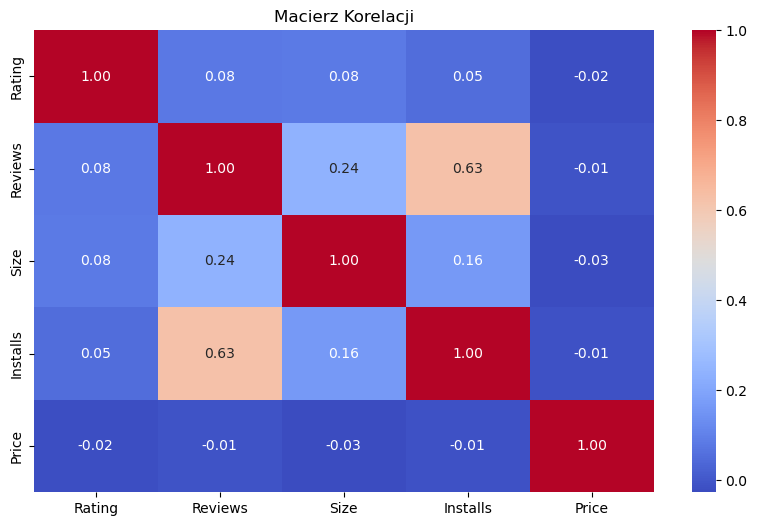

In [13]:
projekt = InstallsPredictor('googleplaystore.csv')

projekt.load_data()          
projekt.clean_data()         

# Tutaj wyświetli się wykres (Macierz Korelacji)
projekt.show_analysis()      


In [14]:
projekt.przygotuj_pipeline() 
projekt.trenuj_i_porownaj()  

# Tworzymy przykładową aplikacje 
aplikacja_malo_znana = {
    'Reviews': 10,
    'Size': 50000000, 
    'Price': 0, 
    'Category': 'GAME', 
    'Type': 'Free', 
    'Content Rating': 'Everyone',
    'Rating': 4.0
}

# Tworzymy wersję "Viralową" 
aplikacja_viralowa = aplikacja_malo_znana.copy()
aplikacja_viralowa['Reviews'] = 100000 

# Zamiana na DataFrame
df_symulacja = pd.DataFrame([aplikacja_malo_znana, aplikacja_viralowa], index=['Wariant Podstawowy', 'Wariant Popularny'])

# Używamy uczenia maszynowego lepszego
wynik = projekt.best_model.predict(df_symulacja)

installs_malo = int(wynik[0])
installs_duzo = int(wynik[1])

print(f"Przewidywane instalacje (Gdy masz mało opinii): {installs_malo:,}")
print(f"Przewidywane instalacje (Gdy zdobędziesz opinie): {installs_duzo:,}")
print(f"Różnica: {installs_duzo - installs_malo:,} nowych użytkowników!")


trenowanie modeli
Przewidywane instalacje (Gdy masz mało opinii): 127,758
Przewidywane instalacje (Gdy zdobędziesz opinie): 5,651,785
Różnica: 5,524,027 nowych użytkowników!
